<a href="https://colab.research.google.com/github/weilainicolas/Trading/blob/main/notebooks/trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd


def find_cross_above_50_200_ma(symbol):
    try:
        today = datetime.now().date()
        # Fetch historical data
        stock_data = yf.download(symbol, period="1y")

        # Calculate moving averages
        stock_data['50MA'] = stock_data['Close'].rolling(window=50).mean()
        stock_data['200MA'] = stock_data['Close'].rolling(window=200).mean()

        # Find dates where 50MA crossed above 200MA
        cross_dates = stock_data[(stock_data['50MA'] > stock_data['200MA']) & (stock_data['50MA'].shift(1) < stock_data['200MA'].shift(1))].index

        # Check if the crossing happened within the last 5 days
        recent_cross_dates = [date for date in cross_dates if (datetime.now() - date).days <= 5]

        return symbol, recent_cross_dates
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return symbol, []

# Get list of S&P 500 symbols
sp500_symbols = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

crossed_stocks = []

# Loop through all S&P 500 symbols
for symbol in sp500_symbols['Symbol']:
    symbol, cross_dates = find_cross_above_50_200_ma(symbol)
    if cross_dates:
        crossed_stocks.append((symbol, cross_dates))

print(crossed_stocks)


/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1

[('KO', [Timestamp('2024-02-12 00:00:00')]), ('INCY', [Timestamp('2024-02-15 00:00:00')]), ('PG', [Timestamp('2024-02-16 00:00:00')]), ('RTX', [Timestamp('2024-02-15 00:00:00')]), ('LUV', [Timestamp('2024-02-15 00:00:00')]), ('STE', [Timestamp('2024-02-12 00:00:00')]), ('TROW', [Timestamp('2024-02-15 00:00:00')])]


In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

def find_stocks_rsi_below_30(symbol):
    try:
        # Fetch historical data
        stock_data = yf.download(symbol,period="1y" )

        # Calculate daily RSI
        delta = stock_data['Close'].diff(1).dropna()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)

        avg_gain = gain.rolling(window=14).mean()
        avg_loss = loss.rolling(window=14).mean()

        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))

        # Check if RSI dropped below 30 within the last 3 days
        if any(rsi.iloc[-4:] < 30):
            return symbol, rsi.iloc[-1]
        else:
            return None
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return None

# Get list of NASDAQ symbols


# Find stocks with RSI below 30 within the last 3 days
stocks_rsi_below_30 = []

# Loop through all NASDAQ symbols
for symbol in sp500_symbols['Symbol']:
    result = find_stocks_rsi_below_30(symbol)
    if result:
        stocks_rsi_below_30.append(result)

# Convert results to DataFrame
df_stocks_rsi_below_30 = pd.DataFrame(stocks_rsi_below_30, columns=['Symbol', 'RSI'])

print(df_stocks_rsi_below_30)


[*********************100%%**********************]  1 of 1 completed
<ipython-input-45-f2f278ade4ab>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Portfolio Value (Strategy)'][i] = close_price * shares + cash


Final Portfolio Value (Strategy): 443.8421768151895
Final Portfolio Value (Buy and Hold): 447.06839642133286


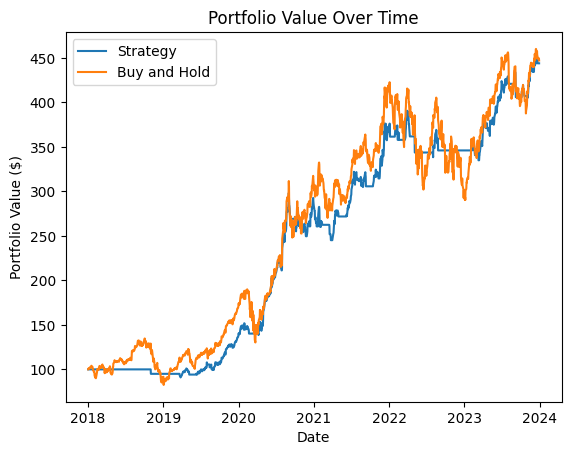

In [45]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fetch historical data
symbol = 'AAPL'
data = yf.download(symbol, start='2018-01-01', end='2024-01-01')

# Calculate moving averages
data['MA200'] = data['Close'].rolling(window=200).mean()
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA15'] = data['Close'].rolling(window=15).mean()
data['Portfolio Value (Strategy)']=0

# Initialize variables
portfolio_value = 100  # Initial portfolio value
cash = portfolio_value     # Initial cash balance
shares = 0                 # Initial number of shares
entry_price = 0            # Entry price
stop_loss = 0.05           # Stop-loss threshold (5% below entry price)
profit_target = 0.1       # Profit-taking threshold (10% profit)
trailing_stop = 0.05       # Trailing stop percentage (5%)
trailing_high = 0          # Highest price since entry

# Backtest the strategy
for i in range(len(data)):
    close_price = data['Close'][i]
    ma200 = data['MA200'][i]
    ma20 = data['MA20'][i]
    ma15 = data['MA15'][i]

    # Buy signal: close price > 200 MA
    if close_price > ma200 and cash > 0:
        shares = cash / close_price
        entry_price = close_price
        cash = 0

    # Update trailing high
    if close_price > trailing_high:
        trailing_high = close_price

    # Stop-loss rule
    if close_price < entry_price * (1 - stop_loss):
        cash += shares * entry_price * (1 - stop_loss)
        shares = 0

    # Profit-taking rule with trailing stop
    if shares > 0:
        profit = (close_price - entry_price) / entry_price
        if profit >= profit_target and close_price < trailing_high * (1 - trailing_stop):
            cash += shares * trailing_high * (1 - trailing_stop)
            shares = 0

    # Sell signal: price falls below 20 MA
    if close_price < ma20:
        cash += shares * close_price
        shares = 0
    data['Portfolio Value (Strategy)'][i] = close_price * shares + cash
# Calculate final portfolio value for the trading strategy
final_portfolio_value_strategy = cash + shares * close_price

# Calculate final portfolio value for the buy-and-hold strategy
buy_and_hold_shares = portfolio_value / data['Close'][0]
final_portfolio_value_buy_and_hold = buy_and_hold_shares * close_price

# Print final portfolio values
print("Final Portfolio Value (Strategy):", final_portfolio_value_strategy)
print("Final Portfolio Value (Buy and Hold):", final_portfolio_value_buy_and_hold)

# Plot portfolio value over time for both strategies
#data['Portfolio Value (Strategy)'] = data['Close'] * shares + cash
data['Portfolio Value (Buy and Hold)'] = buy_and_hold_shares * data['Close']
plt.plot(data['Portfolio Value (Strategy)'], label='Strategy')
plt.plot(data['Portfolio Value (Buy and Hold)'], label='Buy and Hold')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()
